In [25]:
from math import sin, cos, pi
import numpy as np
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import quad
from scipy.spatial.transform import Rotation as R

time - sec  
latitude - deg  
latitude - deg  
altitude - m  
cardinal_angle - deg (clockwise of north)  
elevation_angle - deg (up from horizontal)  
segment_distance - m

In [26]:
df_pos = pd.read_csv('route_time_data.csv')
df_pos

,time,latitude,longitude,altitude,cardinal_angle,elevation_angle,segment_distance
0,395.183352,-12.442441,130.853343,17.588311,29.123942,-0.143553,5428.454894
1,598.718173,-12.436635,130.896946,14.354783,82.239453,-0.033461,5536.800762
2,805.820337,-12.455940,130.942000,35.312645,113.697175,0.212378,5654.017460
3,1010.891394,-12.472004,130.989115,36.231576,109.253521,0.009473,5558.048345
4,1220.004001,-12.507334,131.023048,45.118007,136.843193,0.089072,5716.211014
...,...,...,...,...,...,...,...
514,137271.320954,-34.573047,138.484690,9.515552,136.449087,-0.036572,5809.040188
515,137475.411116,-34.615038,138.519647,15.301404,145.586586,0.057047,5811.057365
516,137689.005990,-34.648548,138.555214,19.749535,138.879270,0.044628,5710.751459
517,137908.093246,-34.645146,138.616966,31.888755,86.185708,0.121645,5717.660393


Checking the time gap between readings

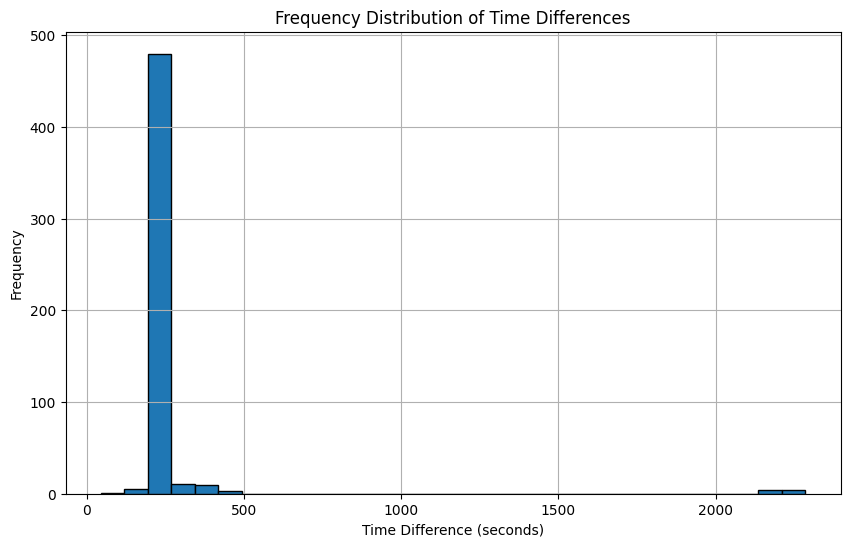

DataFrame with time differences:
      time_diff
1    203.534821
2    207.102164
3    205.071057
4    209.112607
5    202.061822
..          ...
514  210.133906
515  204.090163
516  213.594874
517  219.087256
518   45.531014

[518 rows x 1 columns]


In [27]:
time_diff = df_pos['time'].diff().dropna()
df_time_diff = pd.DataFrame({'time_diff': time_diff})

plt.figure(figsize=(10, 6))
plt.hist(df_time_diff['time_diff'], bins=30, edgecolor='k')
plt.title('Frequency Distribution of Time Differences')
plt.xlabel('Time Difference (seconds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("DataFrame with time differences:")
print(df_time_diff)


Integrating over Array  
Sitting at the drivers seat,  
z - forward  
y - up  
x - left  

In [28]:
def freqplot(df, column):
    plt.figure(figsize=(5, 3))
    df[column].plot(kind='hist', bins=40, edgecolor='black', color='skyblue', title=f'Frequency Distribution of {column}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [29]:
df1 = pd.read_csv('.\locations_set.csv')
df2 = pd.read_csv('.\\normals_set.csv')
df3 = pd.read_csv('.\\areas_set.csv')
df_buf = pd.concat([df1, df2, df3], axis=1)
df_buf

,x_loc,y_loc,z_loc,x_comp,y_comp,z_comp,area
0,426.558750,520.93590,-4012.2520,0.000217,-0.994090,0.108559,1216.623535
1,465.577150,566.39075,-3563.6067,-0.000036,-0.995762,0.091963,898.440369
2,547.429900,646.84690,-2081.3796,-0.000839,-0.999979,0.006385,1337.525879
3,47.330715,594.14350,-3238.9397,-0.000072,-0.996981,0.077651,175.526825
4,342.340600,554.10580,-3692.5000,-0.000294,-0.995260,0.097249,1442.245361
...,...,...,...,...,...,...,...
4423,-10.133422,508.49097,-4124.3647,-0.000306,-0.993707,0.112013,765.454773
4424,-27.877207,506.09457,-4145.5854,0.000109,-0.993650,0.112517,871.459167
4425,-21.133797,511.17236,-4100.5083,0.000257,-0.993782,0.111344,749.101440
4426,-669.423300,478.65552,-4380.8220,0.000192,-0.992916,0.118822,870.442261


Sanity check of data

In [30]:
# freqplot(df_buf, 'x_comp')

# freqplot(df_buf, 'y_comp')

# freqplot(df_buf, 'z_comp')

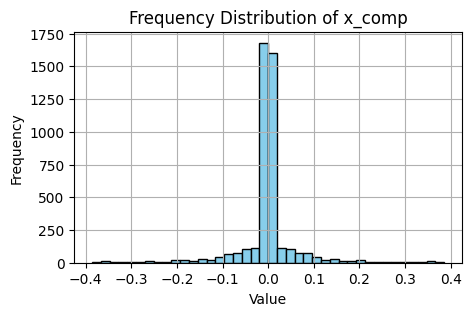

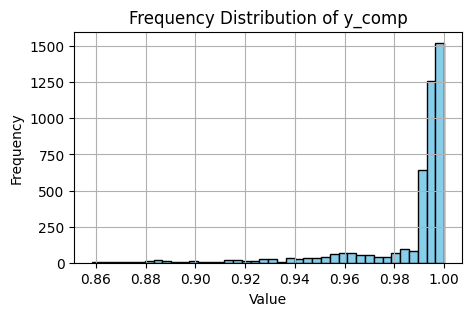

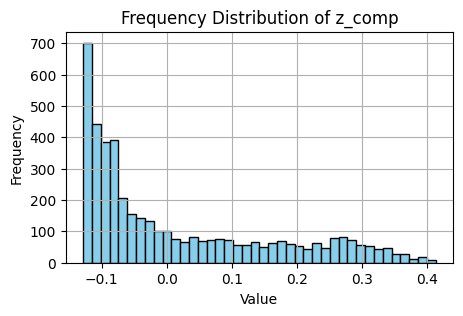

In [31]:
df_car = df_buf[['x_comp', 'y_comp', 'z_comp']]
df_car = df_car.apply(lambda row: -row if row['y_comp'] < 0 else row, axis=1)
df_car['area'] = df_buf['area']

freqplot(df_car, 'x_comp')

freqplot(df_car, 'y_comp')

freqplot(df_car, 'z_comp')

Parameters:

LT -> Local Time (hours)  
del_T_utc -> Difference between Local Time (LT) and Universal Coordinated Time (UTC) (hours)  
d -> No. of days from the start of they year  
La -> Latitude (deg)  
Lo -> Longitude (deg)  
G -> Solar Intensity (W/m^2)

Calculating other parameters:

LSTM -> Local Standard Time Meridian (deg)  
EoT -> Equation of Time (min)  
TC -> Time Correction Factor (min)  
LST -> Local Solar Time (hours)  
HRA -> Hour Angle (deg)  
Dec -> Declination Angle (deg) 

In [32]:
start_time = 8
del_T_utc = 9.5
start_day = 295
G0 = 1360
A = 6
rho = 0.01

In [33]:
def HRA_calc(LT, d, Lo):
    B = 360 * (d - 81) / 365
    LSTM = 15 * del_T_utc
    EoT = 9.87 * sin(pi/180 * 2*B) - 7.53 * cos(pi/180 * B) - 1.5 * sin(pi/180 * B)
    TC = 4 * (Lo - LSTM) + EoT
    LST = np.array(LT) + TC/60
    HRA = 15 * (LST - 12)
    return HRA

# To-Do: Run a check through all the RT functions #

In [34]:
# This function takes cardinal and elevation angle as floats and retuns a tuple of x, y, z (x, y, z can be float or array)
def RT_Cartesian(cardinal_angle, elevation_angle, x_buf, y_buf, z_buf):
    cardinal_angle_r, elevation_angle_r = map(np.radians, (cardinal_angle, elevation_angle))
    
    rotation_x = R.from_euler('x', -elevation_angle_r)
    rotation_y = R.from_euler('y', -cardinal_angle_r)
    net_rotation = rotation_y * rotation_x      # first about x then about y

    x, y, z = net_rotation.apply(np.array([x_buf, y_buf, z_buf]).T).T
    return x, y, z

RT_Cartesian(136.84, 0.09, 0.000294, 0.995260, -0.097249)

(0.06737686532470116, 0.9951060138382779, 0.07227932815757439)

In [35]:
# This function takes cardingal and elevation angle as lists and returns a list of beta and gamma values
def RT_Spherical(cardinal_angle, elevation_angle, beta, gamma):
    x_buf = - np.sin(np.radians(gamma)) * np.sin(np.radians(beta))
    y_buf = np.cos(np.radians(beta))
    z_buf = - np.cos(np.radians(gamma)) * np.sin(np.radians(beta))

    cardinal_angle_r, elevation_angle_r = map(np.radians, (cardinal_angle, elevation_angle))
    rotation_x = R.from_euler('x', -elevation_angle_r)
    rotation_y = R.from_euler('y', -cardinal_angle_r)
    net_rotation = rotation_y * rotation_x      # first about x then about y
    
    x, y, z = zip(*net_rotation.apply([x_buf, y_buf, z_buf]))
    beta_new = np.degrees(-np.arccos(y))
    gamma_new = np.degrees(np.arctan2(x, z))
    return beta_new, gamma_new

*** Tilting is towards the left from the drivers pov (the right side raises) ***

In [36]:
# This function takes cardinal and tilt angle as floats and retuns a tuple of x, y, z (x, y, z can be float or array)
# Tilting is towards the left from the drivers pov (the right side raises)
def RT_Tilt(cardinal_angle, tilt, x_buf, y_buf, z_buf):
    cardinal_angle_r, tilt_r = map(np.radians, (cardinal_angle, tilt))
    
    rotation_x = R.from_euler('z', -tilt_r)
    rotation_y = R.from_euler('y', -cardinal_angle_r)
    net_rotation = rotation_y * rotation_x      # first about z then about y

    x, y, z = net_rotation.apply(np.array([x_buf, y_buf, z_buf]).T).T
    return x, y, z

RT_Tilt(30, 90, 0, 1, 0)

(0.8660254037844387, 1.1102230246251565e-16, 0.5)

Beta -> Angle of Plane of Panel with Horizontal (deg)   
Gamma -> Azimuth Angle (deg)  
A -> Area of Panel

Power function for a single flat solar cell

In [37]:
# def Power_Panel(A, beta, gamma, LT, d, La, Lo, Alt):
    
#     Dec = -23.45 * cos(2*pi * (d + 10) / 365)
#     HRA = HRA_calc(LT, d, Lo)
    
#     Dec_r, beta_r, gamma_r, La_r, HRA_r = map(np.radians, (Dec, beta, gamma, La, HRA))

#     theta = np.arccos(np.sin(Dec_r)*np.sin(La_r)*np.cos(beta_r) - np.sin(Dec_r)*np.cos(La_r)*np.sin(beta_r)*np.cos(gamma_r) +
#                     np.cos(Dec_r)*np.cos(La_r)*np.cos(beta_r)*np.cos(HRA_r) + np.cos(Dec_r)*np.sin(La_r)*np.sin(beta_r)*np.cos(gamma_r)*np.cos(HRA_r) +
#                     np.cos(Dec_r)*np.sin(beta_r)*np.sin(gamma_r)*np.sin(HRA_r))
    
#     power = G0 * A * np.cos(theta)
#     return power

In [38]:
def Power_Panel(A, beta, gamma, LT, d, La, Lo, Alt):     # output: W

    Dec = -23.45 * cos(2*pi * (d + 10) / 365)
    HRA = HRA_calc(LT, d, Lo)
    A0 = 0.4237 - 0.00821*(6-Alt*0.001)**2
    A1 = 0.5055 - 0.00595*(0.5-Alt*0.001)**2
    k = 0.2711 + 0.01858*(2.5-Alt*0.001)**2
    
    Dec_r, beta_r, gamma_r, La_r, HRA_r = map(np.radians, (Dec, beta, gamma, La, HRA))

    theta = np.arccos(np.sin(Dec_r)*np.sin(La_r)*np.cos(beta_r) - np.sin(Dec_r)*np.cos(La_r)*np.sin(beta_r)*np.cos(gamma_r) +
                      np.cos(Dec_r)*np.cos(La_r)*np.cos(beta_r)*np.cos(HRA_r) + np.cos(Dec_r)*np.sin(La_r)*np.sin(beta_r)*np.cos(gamma_r)*np.cos(HRA_r) +
                      np.cos(Dec_r)*np.sin(beta_r)*np.sin(gamma_r)*np.sin(HRA_r))
    
    thetaz = np.arccos(np.sin(Dec_r)*np.sin(La_r)*np.cos(0) - np.sin(Dec_r)*np.cos(La_r)*np.sin(0)*np.cos(0) +
                      np.cos(Dec_r)*np.cos(La_r)*np.cos(0)*np.cos(HRA_r) + np.cos(Dec_r)*np.sin(La_r)*np.sin(0)*np.cos(0)*np.cos(HRA_r) +
                      np.cos(Dec_r)*np.sin(0)*np.sin(0)*np.sin(HRA_r))
    
    Gb = G0 * (1 + 0.034 * np.cos(np.radians(360 * d / 365.25))) * (A0 + A1 * np.exp(-k / np.cos(thetaz)))
    Gd = G0 * (1 + 0.034 * np.cos(np.radians(360 * d / 365.25))) * np.cos(thetaz) * (0.2710 - 0.2931 * (A0 + A1 * np.exp(-k / np.cos(thetaz))))
    Gg = G0 * rho * ((1 - np.cos(np.radians(beta))) / 2)
    G = Gb * (np.cos(theta) / np.cos(thetaz)) + Gd * ((1 + np.cos(np.radians(beta))) / 2) + Gg

    power = G * A * np.cos(theta)
    return power

Power_Panel(6, 0, 0, start_time+4, start_day, df_pos.loc[0, 'latitude'], df_pos.loc[0, 'longitude'], df_pos.loc[0, 'altitude'])

4938.890016036072

Energy function for a single flat solar cell

In [39]:
def Energy_Panel(A, beta, gamma, df_pos):       # output: kWh
    df_pos_plus = df_pos.copy()
    time_diff = df_pos['time'].diff()
    df_pos_plus['time_diff'] = time_diff.fillna(0)
    df_pos_plus['local_time'] = 8 + ((df_pos['time'] / 3600) % 9)
    df_pos_plus['day'] = start_day + df_pos['time'] // (9*3600)

    df_pos_plus['beta_new'], df_pos_plus['gamma_new'] = RT_Spherical(df_pos_plus['cardinal_angle'], df_pos_plus['elevation_angle'], beta, gamma)

    energy = (df_pos_plus['time_diff'] * df_pos_plus.apply(lambda row: Power_Panel(A, row['beta_new'], row['gamma_new'], row['local_time'], row['day'], row['latitude'], row['longitude'], row['altitude']), axis=1)).sum()
    return energy/3600000

Energy_Panel(A, 30.0, 0.0, df_pos)

132.4955509350217

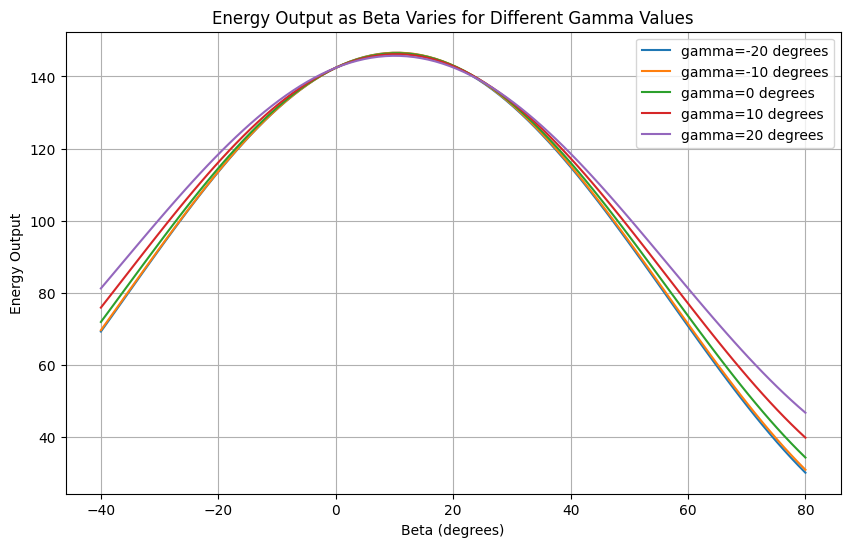

In [40]:
beta_values = np.linspace(-40, 80, 100)
gamma_values = [-20, -10, 0, 10, 20]
plt.figure(figsize=(10, 6))
for gamma in gamma_values:
    energy_outputs = [Energy_Panel(A, beta, gamma, df_pos) for beta in beta_values]
    plt.plot(beta_values, energy_outputs, label=f'gamma={gamma} degrees')

plt.title('Energy Output as Beta Varies for Different Gamma Values')
plt.xlabel('Beta (degrees)')
plt.ylabel('Energy Output')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
bounds = [(-180, 180), (-180, 180)]
initial_guess = [0, 0]

result = minimize(lambda vars, A, df_pos : -Energy_Panel(A, vars[0], vars[1], df_pos), initial_guess, args=(A, df_pos), bounds=bounds, method='L-BFGS-B')
optimal_beta, optimal_gamma = result.x
max_energy_output = -result.fun

print(f"Optimal beta: {optimal_beta}")
print(f"Optimal gamma: {optimal_gamma}")
print(f"Maximum Energy Output: {max_energy_output} kWh")

Optimal beta: 10.398787069400633
Optimal gamma: -13.550735020443764
Maximum Energy Output: 146.58487436488866 kWh


********* Power_Array_Standing and Power_Array_Racing are very similar, could add a flag and make it 1 function *********  
********* Also, if the above functions + energy ones could we add a variable called ST_coords to reduce the args *********


Power function for a solar array with beta and gamma values

In [42]:
def Power_Array_Racing(card_angle, ele_angle, LT, d, La, Lo, Alt, df_car):

    x_buf, y_buf, z_buf, a = df_car['x_comp'], df_car['y_comp'], df_car['z_comp'], df_car['area']

    x, y, z = RT_Cartesian(card_angle, ele_angle, x_buf, y_buf, z_buf)
    y = np.clip(y, -1, 1)

    a = a/1000000                                           # Converting mm^2 to m^2
    beta = np.degrees(-np.arccos(y))
    gamma = np.degrees(np.arctan2(x, z))
    total_power = Power_Panel(a, beta, gamma, LT, d, La, Lo, Alt).sum()

    return total_power

Power_Array_Racing(136.84, 0.09, 12, 232, -12.51, 131.02, 45, df_car)

3371.403405825494

Energy function for a solar array with beta and gamma values

In [43]:
def Energy_Array_Racing(df_pos, df_car):       # output: kWh
    df_pos_plus = df_pos.copy()
    time_diff = df_pos['time'].diff()
    df_pos_plus['time_diff'] = time_diff.fillna(0)
    df_pos_plus['local_time'] = 8 + ((df_pos['time'] / 3600) % 9)
    df_pos_plus['day'] = start_day + df_pos['time'] // (9*3600)

    df_pow = pd.DataFrame()
    df_pow['power'] = df_pos_plus.apply(lambda row: Power_Array_Racing(row['cardinal_angle'], row['elevation_angle'], row['local_time'], row['day'], row['latitude'], row['longitude'], row['altitude'], df_car), axis=1)
    df_pow['time'] = df_pos['time']
    energy = np.trapz(df_pow['power'], df_pow['time'])

    return energy/3600000, df_pow

total_energy, df_pow = Energy_Array_Racing(df_pos, df_car)
print(total_energy)

116.22017578398024


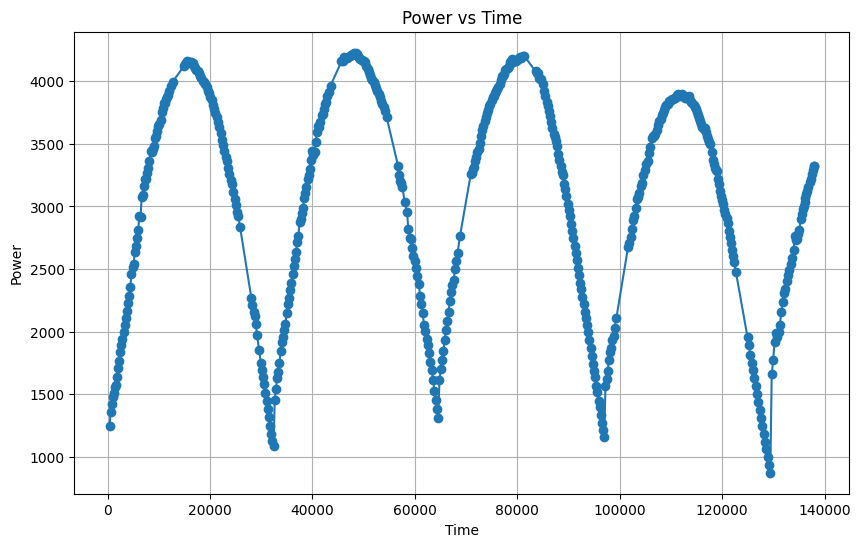

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(df_pow['time'], df_pow['power'], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Power')
plt.title('Power vs Time')
plt.grid(True)
plt.show()

In [45]:
def Power_Array_Standing(card_angle, tilt, LT, d, La, Lo, Alt, df_car):
    total_power = 0

    x_buf, y_buf, z_buf, a = df_car['x_comp'], df_car['y_comp'], df_car['z_comp'], df_car['area']

    x, y, z = RT_Tilt(card_angle, tilt, x_buf, y_buf, z_buf)
    y = np.clip(y, -1, 1)

    a = a/1000000
    beta = np.degrees(-np.arccos(y))
    gamma = np.degrees(np.arctan2(x, z))
    total_power = Power_Panel(a, beta, gamma, LT, d, La, Lo, Alt).sum()

    return total_power

Power_Array_Standing(136.84, 0.09, 12, 232, -12.51, 131.02, 45, df_car)

3368.2514410447084

In [46]:
def Energy_Array_Standing(card_angle, tilt, LT_start, LT_stop, d, La, Lo, Alt, df_car):       # output: kWh
    N = 100                                         # Number of divisions of the time frame (try varying this)
    time_array = np.linspace(LT_start, LT_stop, N, endpoint=True)      # Verify if we need the last point (np.trapz)
    df_pow = pd.DataFrame()
    df_pow['time'] = time_array
    df_pow['power'] = df_pow.apply(lambda row: Power_Array_Standing(card_angle, tilt, row['time'], d, La, Lo, Alt, df_car), axis=1)
    # for t in time_array:
    #     df_pow['power'].append()
    #     # Take inspiration from below, maybe make time_array into a pandas dataframe and use .apply
    #     # df_pow['power'] = df_pos_plus.apply(lambda row: Power_Array(row['cardinal_angle'], row['elevation_angle'], row['local_time'], row['day'], row['latitude'], row['longitude'], row['altitude'], df_car), axis=1)
    energy = np.trapz(df_pow['power'], df_pow['time'])

    return energy/1000

Energy_Array_Standing(136.84, 0.09, 12, 13, 232, -12.51, 131.02, 45, df_car)

3.4433595538622095

Figuring out Power / Energy during Control Stops, Start and End of the Day

In [47]:
def Tilt_Angle(LT_start, LT_stop, d, La, Lo, Alt, df_car):
    bounds = [(-180, 180), (0, 90)]
    initial_guess = [0, 0]
    result = minimize(lambda vars, LT_start, LT_stop, d, La, Lo, Alt, df_car : -Energy_Array_Standing(vars[0], vars[1], LT_start, LT_stop, d, La, Lo, Alt, df_car), \
                      initial_guess, args=(LT_start, LT_stop, d, La, Lo, Alt, df_car), bounds=bounds, method='L-BFGS-B')
    
    optimal_tilt, optimal_card_angle = result.x
    max_energy_output = -result.fun
    return optimal_tilt, optimal_card_angle, max_energy_output


optimal_tilt, optimal_card_angle, max_energy_output = Tilt_Angle(10, 10.5, 232, -12.51, 131.02, 45, df_car)
print(f"Optimal Tilt: {optimal_tilt}")
print(f"Optimal Cardinal angle: {optimal_card_angle}")
print(f"Maximum Energy Output: {max_energy_output} kWh")

Optimal Tilt: 32.142307932384874
Optimal Cardinal angle: 44.10218858250154
Maximum Energy Output: 2.243914584633953 kWh
